## BKM and FNC Implementation

### Omelyusik Vladimir

### Spectral Economists Team

#### Imports
---

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.linalg import sqrtm
import pandas as pd
from sklearn.datasets import make_blobs
np.random.seed(123)
from sklearn.metrics import accuracy_score
import time
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

#### Implementation based on article
---

In [306]:
# https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
def BKM(X, gamma, c, n_steps):
    '''
    Implementation of Balanced K-Means (Algorithm 2).
    
    Attributes:
    ---
    X: ndarray
        Matrix (dxn), d is the number of features, n is the number of observations.
    gamma: float
        Regularization parameter.
    c: int
        Number of clusters.
    n_steps: int
        Number of iterations.
    
    Returns:
    ---
    F: ndarray
        Matrix (nxc) with predicted clusters.
    '''
    n = X.shape[1]
    A = np.random.normal(size=(n, c))
    F = np.zeros_like(A)
    F[np.arange(len(A)), A.argmax(1)] = 1
    F[:c, :c] = np.identity(c)
    
    for i in range(n_steps):
        H = X @ F @ np.linalg.pinv(F.T @ F)
        F_new = F.copy()
        j = 0
        while (np.linalg.norm(F_new - F) == 0) & (j < 10):
            G = (n * gamma * np.identity(n) - gamma * np.ones(n).reshape(-1, 1) @ (np.ones(n).reshape(-1, 1).T)) @ F
            Q = G + X.T @ H - 1/2 * np.ones(n).reshape(-1, 1) @ (np.ones(X.shape[0]).reshape(-1, 1).T) @ (H * H)
            F_new = np.zeros_like(F_new)
            F_new[np.arange(len(Q)), Q.argmax(1)] = 1
            j += 1
        F = F_new.copy()
    
    return F

In [307]:
# https://stackoverflow.com/questions/48312205/find-the-k-nearest-neighbours-of-a-point-in-3d-space-with-python-numpy

def construct_similarity_matrix(X, W, k):
    '''
    Calculates the similarity matrix.
    
    Attributes:
    ---
    X: ndarray
        Matrix (dxn), d is the number of features, n is the number of observations.
    W: ndarray
        Matrix XF inv(F'F) where F is cluster indicator matrix
    k: int
        Number of neighbours.
    
    Returns:
    ---
    B: ndarray
        Similarity matrix (nxm).
    '''
    B = np.zeros((X.shape[1], W.shape[1]))
    D = distance.squareform(distance.pdist(X.T)) # Matrix of distances n x n 
    closest = np.argsort(D, axis=1)
    closest_inds = closest[:, 1 : k+2] # Indices of rows closest to row i, n x k
    
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
            if j in closest_inds[i, :-1]:
                B[i, j] = (((D[i, closest_inds[i, -1]]) ** 2) - np.linalg.norm(X[:, i] - W[:, j]) ** 2) /\
                (k * ((D[i, closest_inds[i, -1]]) ** 2) - np.sum((D[i, closest_inds[i, :-1]]) ** 2))
            else:
                B[i, j] = 0
    
    return B

In [308]:
def FNC(X, k, m, gamma, n_steps):
    '''
    Implementation of Fast Normalized Cut (Algorithm 3) from the article.
    
    Attributes:
    ---
    X: ndarray
        Matrix (dxn), d is the number of features, n is the number of observations.
    k: int
        Number of neighbours.
    m: int
        Number of clusters for BKM.
    gamma: float
        Regularization parameter.
    n_steps: int
        Number of iterations.
    
    Returns:
    ---
    Y: ndarray
        Matrix (nxc) with predicted clusters.
    '''
    n = X.shape[1]
    clusters = BKM(X, gamma, m, 100)
    
    W = X @ clusters @ np.linalg.pinv(clusters.T @ clusters)
    B = construct_similarity_matrix(X, W, k)
    delta = np.diag(np.sum(B, axis = 0).tolist())
    PPT = B @ np.linalg.pinv(delta) @ B.T
    
    A = np.random.normal(size=(n, m))
    Y = np.zeros_like(A)
    Y[np.arange(len(A)), A.argmax(1)] = 1
    
    for k in range(n_steps):
        G = PPT @ Y @ np.linalg.pinv(sqrtm(Y.T @ Y))
        s = np.zeros_like(Y)
        for i in range(s.shape[0]):
            for l in range(s.shape[1]):
                s[i, l] = ((Y[:, l].T @ G[:, l] + G[i, l] * (1 - Y[i, l])) /\
                np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\
                np.sqrt(Y[:, l].T @ Y[:, l] - Y[i, l]))
        Y_new = np.zeros_like(Y)
        Y_new[np.arange(len(s)), s.argmax(1)] = 1
        Y = Y_new.copy()
    
    return Y

In [322]:
def accuracy(y_true, clusters_labels):
    clusters=np.unique(clusters_labels)
    y_pred=np.empty(len(y_true))
    
    for cluster in clusters:
      
        mask_cluster=clusters_labels==cluster
        mean_pred=np.bincount(y_true[mask_cluster]).argmax()
        y_pred[mask_cluster]=mean_pred
    accur=accuracy_score(y_true, y_pred)
    return accur

#### Experiments
---

1. `sklearn` blobs
---

In [319]:
blobs = make_blobs()
X = blobs[0]
y = blobs[1]

BKM time: 0.39194250106811523


Text(0.5, 1.0, 'BKM: Blobs Predictions')

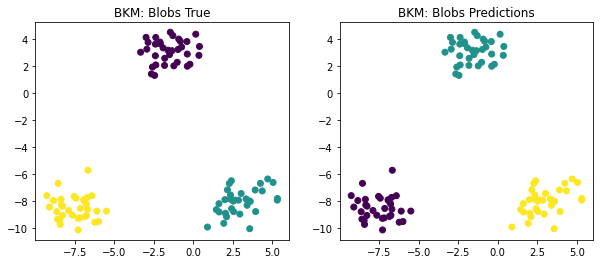

In [325]:
start = time.time()
pred = BKM(X.T, 0.1, 3, 100)
print('BKM time:', time.time() - start)
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].scatter(X[:, 0], X[:, 1], c = y)
ax[0].set_title('BKM: Blobs True')
ax[1].scatter(X[:, 0], X[:, 1], c = np.argmax(pred, axis = 1))
ax[1].set_title('BKM: Blobs Predictions')

In [326]:
accuracy(y, np.argmax(pred, axis = 1))

1.0

In [333]:
start = time.time()
pred = FNC(X.T, 2000, 3, 1e-2, 300)
print('FNC time:', time.time() - start)

FNC time: 2.794888973236084


In [335]:
pred2 = FNC(X.T, 50, 3, 1e-2, 300)

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


In [339]:
accuracy(y, np.argmax(pred2, axis = 1))

0.44

Text(0.5, 0, 'accuracy = 0.44')

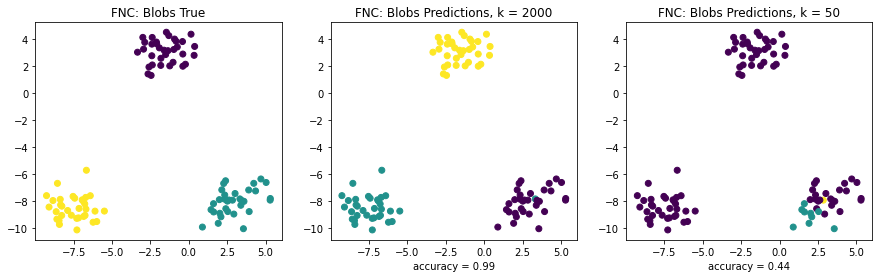

In [340]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
ax[0].scatter(X[:, 0], X[:, 1], c = y)
ax[0].set_title('FNC: Blobs True')
ax[1].scatter(X[:, 0], X[:, 1], c = np.argmax(pred, axis = 1))
ax[1].set_title('FNC: Blobs Predictions, k = 2000')
ax[1].set_xlabel('accuracy = 0.99')
ax[2].scatter(X[:, 0], X[:, 1], c = np.argmax(pred2, axis = 1))
ax[2].set_title('FNC: Blobs Predictions, k = 50')
ax[2].set_xlabel('accuracy = 0.44')

In [332]:
accuracy(y, np.argmax(pred, axis = 1))

0.99

2. `isolet5`
---

In [375]:
data = pd.read_csv('Data/isolet5.data')

In [376]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [343]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 26, 100)
print(time.time() - start)

82.86659622192383


In [344]:
print('BKM accuracy:')
accuracy(y, np.argmax(pred, axis = 1))

BKM accuracy:


0.09563543003851091

In [345]:
start = time.time()
pred = FNC(np.array(X.T), 20, 26, 0.1, 100)
print(time.time() - start)

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


244.41758942604065


In [346]:
print('FNC accuracy:')
accuracy(y, np.argmax(pred, axis = 1))

FNC accuracy:


0.038510911424903725

In [377]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 13, 100)
print(time.time() - start)
print('BKM accuracy:')
accuracy(y, np.argmax(pred, axis = 1))

70.16538214683533
BKM accuracy:


0.07509627727856226

In [378]:
start = time.time()
pred = FNC(np.array(X.T), 20, 13, 0.1, 100)
print(time.time() - start)
print('FNC accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


152.08266043663025
FNC accuracy:
0.038510911424903725


In [379]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 30, 100)
print(time.time() - start)
print('BKM accuracy:')
accuracy(y, np.argmax(pred, axis = 1))

84.75844645500183
BKM accuracy:


0.10012836970474968

In [380]:
start = time.time()
pred = FNC(np.array(X.T), 20, 30, 0.1, 100)
print(time.time() - start)
print('FNC accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


277.4200403690338
FNC accuracy:
0.038510911424903725


3. `segments`
---

In [367]:
data = pd.read_csv('Data/segments.csv')

In [368]:
X = data.iloc[:, 1:-1]
y = data['class']
len(np.unique(y))

7

In [349]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 7, 100)
print('BKM time:')
print(time.time() - start)
print('BKM accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

BKM time:
84.27114772796631
BKM accuracy:
0.5177489177489177


In [350]:
start = time.time()
pred = FNC(np.array(X).T, 20, 7, 0.1, 100)
print('FNC time:')
print(time.time() - start)
print('FNC accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


FNC time:
153.7147135734558
FNC accuracy:
0.14285714285714285


In [369]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 3, 100)
print('BKM time:')
print(time.time() - start)
print('BKM accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

BKM time:
89.83737206459045
BKM accuracy:
0.3562770562770563


In [370]:
start = time.time()
pred = FNC(np.array(X).T, 20, 3, 0.1, 100)
print('FNC time:')
print(time.time() - start)
print('FNC accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


FNC time:
137.1716606616974
FNC accuracy:
0.14285714285714285


In [371]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 10, 100)
print('BKM time:')
print(time.time() - start)
print('BKM accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

BKM time:
119.00968718528748
BKM accuracy:
0.6038961038961039


In [372]:
start = time.time()
pred = FNC(np.array(X).T, 20, 10, 0.1, 100)
print('FNC time:')
print(time.time() - start)
print('FNC accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


FNC time:
241.94911670684814
FNC accuracy:
0.14285714285714285


4. `glass`
---

In [391]:
data = pd.read_csv('Data/glass_processed.csv')

In [392]:
X = data.iloc[:, 1:-1]
y = data['target']
len(np.unique(y))

6

In [361]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 6, 100)
print('BKM time:')
print(time.time() - start)
print('BKM accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

BKM time:
0.8450148105621338
BKM accuracy:
0.411214953271028


In [362]:
start = time.time()
pred = FNC(np.array(X).T, 20, 6, 0.1, 100)
print('FNC time:')
print(time.time() - start)
print('FNC accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


FNC time:
4.29346489906311
FNC accuracy:
0.35514018691588783


In [363]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 3, 100)
print('BKM time:')
print(time.time() - start)
print('BKM accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

BKM time:
0.9201807975769043
BKM accuracy:
0.35514018691588783


In [364]:
start = time.time()
pred = FNC(np.array(X).T, 20, 3, 0.1, 100)
print('FNC time:')
print(time.time() - start)
print('FNC accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


FNC time:
2.8923938274383545
FNC accuracy:
0.35514018691588783


In [365]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 9, 100)
print('BKM time:')
print(time.time() - start)
print('BKM accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

BKM time:
0.9788575172424316
BKM accuracy:
0.411214953271028


In [366]:
start = time.time()
pred = FNC(np.array(X).T, 20, 9, 0.1, 100)
print('FNC time:')
print(time.time() - start)
print('FNC accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


FNC time:
6.70219612121582
FNC accuracy:
0.35514018691588783


In [415]:
fnc_acc = []
bkm_acc = []
k = [10, 20, 40, 50, 100, 120, 150, 200, 500, 1000]

for i in k:
    #pred_bkm = BKM(np.array(X).T, 0.1, 9, 100)
    pred_fnc = FNC(np.array(X).T, i, 3, 0.1, 100)
    fnc_acc.append(accuracy(y, np.argmax(pred_fnc, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


Text(0.5, 1.0, 'Accuracy of FNC depending on number of neigbours (glass)')

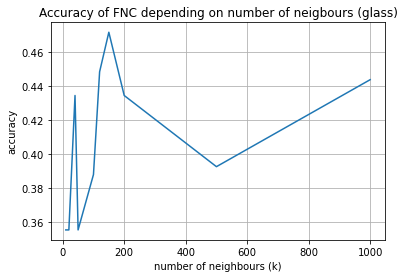

In [416]:
plt.plot(k, fnc_acc)
plt.grid()
plt.xlabel('number of neighbours (k)')
plt.ylabel('accuracy')
plt.title('Accuracy of FNC depending on number of neigbours (glass)')

In [420]:
fnc_acc = []
bkm_acc = []
m = [3, 6, 9, 12, 24, 48]

for i in m:
    pred_bkm = BKM(np.array(X).T, 0.1, i, 100)
    pred_fnc = FNC(np.array(X).T, 20, i, 0.1, 100)
    fnc_acc.append(accuracy(y, np.argmax(pred_fnc, axis = 1)))
    bkm_acc.append(accuracy(y, np.argmax(pred_bkm, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


Text(0, 0.5, 'accuracy')

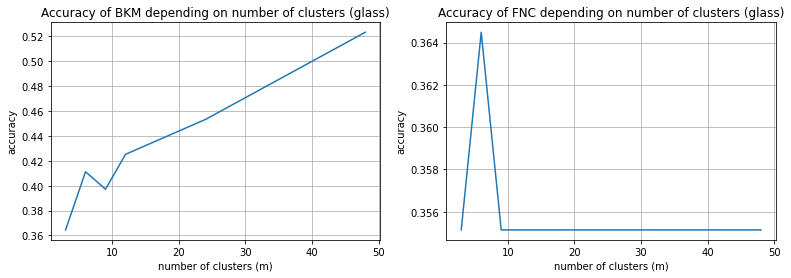

In [421]:
fig, ax = plt.subplots(1, 2, figsize = (13, 4))
ax[0].plot(m, bkm_acc)
ax[0].set_title('Accuracy of BKM depending on number of clusters (glass)')
ax[0].grid()
ax[0].set_xlabel('number of clusters (m)')
ax[0].set_ylabel('accuracy')
ax[1].plot(m, fnc_acc)
ax[1].set_title('Accuracy of FNC depending on number of clusters (glass)')
ax[1].grid()
ax[1].set_xlabel('number of clusters (m)')
ax[1].set_ylabel('accuracy')

In [417]:
fnc_acc = []
bkm_acc = []
gamma = [1e-4, 1e-3, 1e-2, 1e-1, 1]

for i in gamma:
    pred_bkm = BKM(np.array(X).T, i, 6, 100)
    pred_fnc = FNC(np.array(X).T, 20, 6, i, 100)
    fnc_acc.append(accuracy(y, np.argmax(pred_fnc, axis = 1)))
    bkm_acc.append(accuracy(y, np.argmax(pred_bkm, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


Text(0, 0.5, 'accuracy')

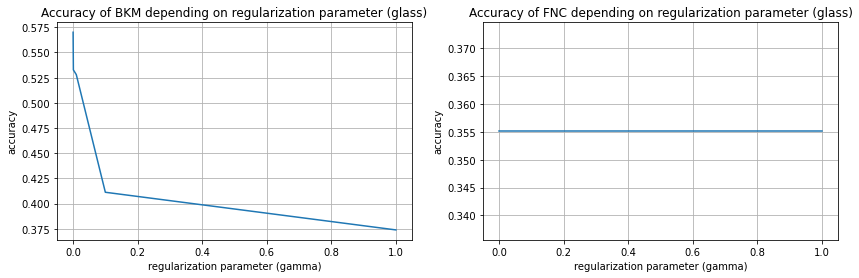

In [419]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(gamma, bkm_acc)
ax[0].set_title('Accuracy of BKM depending on regularization parameter (glass)')
ax[0].grid()
ax[0].set_xlabel('regularization parameter (gamma)')
ax[0].set_ylabel('accuracy')
ax[1].plot(gamma, fnc_acc)
ax[1].set_title('Accuracy of FNC depending on regularization parameter (glass)')
ax[1].grid()
ax[1].set_xlabel('regularization parameter (gamma)')
ax[1].set_ylabel('accuracy')

5. `MNIST`
---

In [381]:
mnist=pd.read_csv('https://pkgstore.datahub.io/machine-learning/mnist_784/mnist_784_csv/data/89c44af4c515d5a3c132bc3cc298a6bd/mnist_784_csv.csv')
X_mnist=mnist.drop('class',axis=1)
y_mnist=mnist['class']

In [386]:
X = X_mnist[:6000]
y = y_mnist[:6000]

In [387]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 10, 100)
print('BKM time:')
print(time.time() - start)
print('BKM accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

BKM time:
302.43964171409607
BKM accuracy:
0.591


In [388]:
start = time.time()
pred = FNC(np.array(X).T, 20, 10, 0.1, 100)
print('FNC time:')
print(time.time() - start)
print('FNC accuracy:')
print(accuracy(y, np.argmax(pred, axis = 1)))

<ipython-input-308-248496089200>:41: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\


FNC time:
1805.6319298744202
FNC accuracy:
0.11183333333333334
